In [1]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [2]:
def get_date_taken(path):
    return Image.open(path)._getexif()[36867]

In [9]:
# files = glob("data/transform/tlux/**")
files = glob("tmp/1/*.jpeg")
s_images = sorted([(get_date_taken(p), p) for p in files])
ref_image_path = s_images[0][1]
files

['tmp/1/DA20F217-EB20-4CDD-B39D-8A10EB081DB4.jpeg',
 'tmp/1/CDA55988-5FD6-4633-ADA9-387980341963.jpeg']

In [10]:
import cv2 
import numpy as np 
  
def transform(reference, img):
    # Open the image files. 
    img1_color = cv2.imread(img)  # Image to be aligned. 
    img2_color = cv2.imread(reference)    # Reference image.     # Convert to grayscale. 
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY) # image to be aligned
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY) # reference image
    height, width = img2.shape 

    # Create ORB detector with 5000 features. 
    orb_detector = cv2.ORB_create(5000) 

    # Find keypoints and descriptors. 
    # The first arg is the image, second arg is the mask 
    #  (which is not reqiured in this case). 
    kp1, d1 = orb_detector.detectAndCompute(img1, None) 
    kp2, d2 = orb_detector.detectAndCompute(img2, None) 

    # Match features between the two images. 
    # We create a Brute Force matcher with  
    # Hamming distance as measurement mode. 
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 

    # Match the two sets of descriptors. 
    matches = matcher.match(d1, d2) 

    # Sort matches on the basis of their Hamming distance. 
    matches.sort(key = lambda x: x.distance) 

    # Take the top 90 % matches forward. 
    matches = matches[:int(len(matches)*90)] 
    no_of_matches = len(matches) 

    # Define empty matrices of shape no_of_matches * 2. 
    p1 = np.zeros((no_of_matches, 2)) 
    p2 = np.zeros((no_of_matches, 2)) 

    for i in range(len(matches)): 
        p1[i, :] = kp1[matches[i].queryIdx].pt 
        p2[i, :] = kp2[matches[i].trainIdx].pt 

    # Find the homography matrix. 
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC) 

    # Use this matrix to transform the 
    # colored image wrt the reference image. 
    transformed_img = cv2.warpPerspective(img1_color, 
                        homography, (width, height)) 
    return transformed_img
    # Save the output. 
#     cv2.imwrite('output.jpg', transformed_img) 

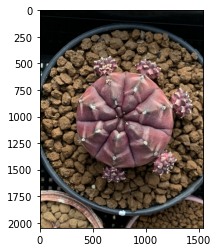

<Figure size 432x288 with 0 Axes>

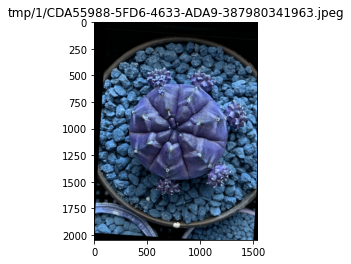

In [14]:
first_im = Image.open(s_images[0][1])
plt.imshow(first_im)
for i, (_, img_path) in enumerate(s_images[1:]):
    plt.figure()
    trans = transform(ref_image_path, img_path)
    plt.figure()
    plt.title(img_path)
    plt.imshow(trans)
    plt.show()

In [19]:
!open .